# 📌 Step 1: Install & Import Required Libraries & Load Dataset

In [58]:
# Install libraries if needed
!pip install seaborn --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Display settings
pd.set_option('display.max_columns', None)

# Load data
df = pd.read_csv('/content/air_pollution_data.csv')
df.columns = df.columns.str.strip()

print(f"✅ Data loaded: {df.shape}")
df.head()


✅ Data loaded: (23504, 11)


,city,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Ahmedabad,30-11-2020,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36
1,Ahmedabad,01-12-2020,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36
2,Ahmedabad,02-12-2020,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12
3,Ahmedabad,03-12-2020,5,2296.45,41.57,40.10,0.00,35.76,150.37,202.15,36.48
4,Ahmedabad,04-12-2020,5,2189.64,23.92,58.95,0.02,28.13,160.79,205.80,40.53


Step 2: Data Preprocessing

In [48]:
# Explore missing values
print("🔷 Missing values per column:")
print(df.isnull().sum())

# Replace invalid values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

# Fill missing values only for numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


# Drop non-numeric columns (if any left that are not needed for Prophet)
# The 'city' column is not numeric and not used by Prophet's core model or as a regressor in the current plan
df_numeric = df.select_dtypes(include=[np.number])


print(f"✅ Data after cleaning: {df_numeric.shape}")
df_numeric.head()

🔷 Missing values per column:
city     0
date     0
aqi      0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64
✅ Data after cleaning: (23504, 9)


,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36
1,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36
2,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12
3,5,2296.45,41.57,40.10,0.00,35.76,150.37,202.15,36.48
4,5,2189.64,23.92,58.95,0.02,28.13,160.79,205.80,40.53


Step 3: Exploratory Data Analysis (EDA)

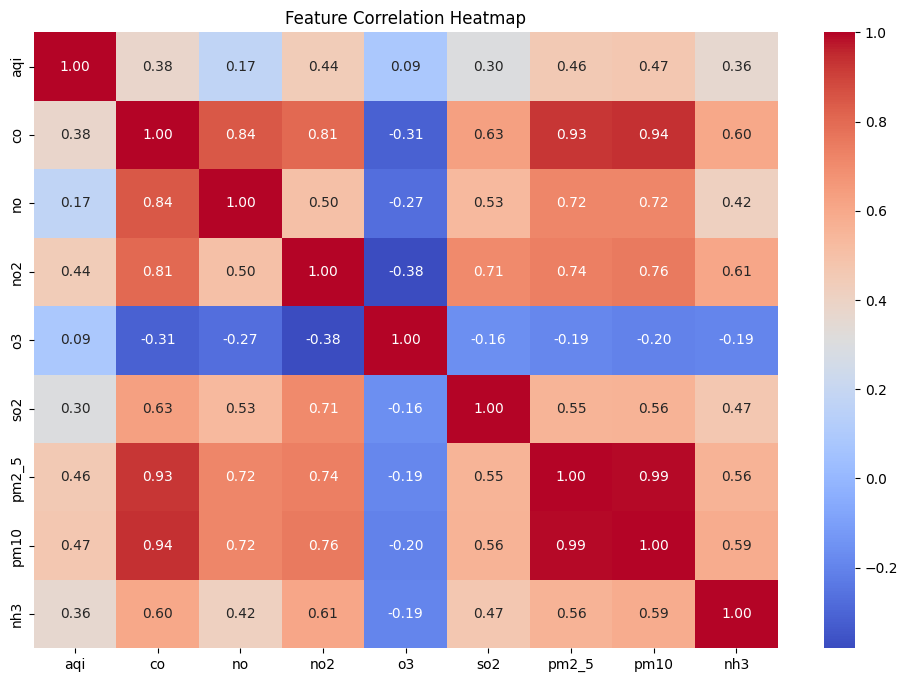

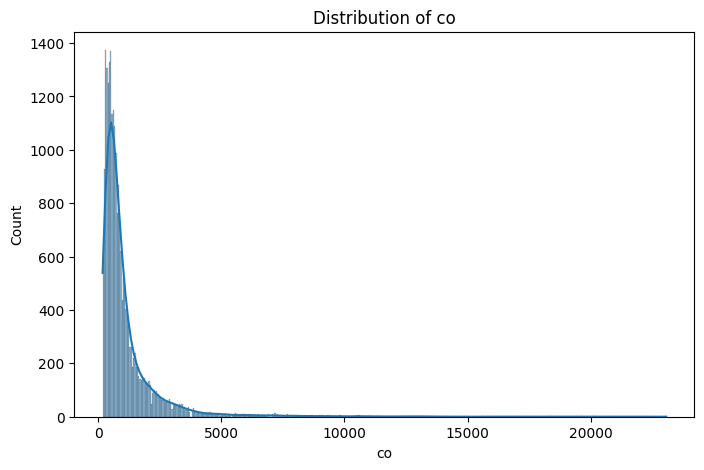

In [50]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Distribution of target
target_column = 'co'  # 👈 Replace with correct target
plt.figure(figsize=(8,5))
sns.histplot(df_numeric[target_column], kde=True)
plt.title(f"Distribution of {target_column}")
plt.show()

 Step 4: Feature Scaling

In [51]:
# Split into features & target
X = df_numeric.drop(target_column, axis=1)
y = df_numeric[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


📌 Step 5: Model Selection & Hyperparameter Tuning

In [52]:
# Define models & parameters
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# Grid Search CV
print("🔷 Tuning Random Forest...")
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

print("🔷 Tuning Gradient Boosting...")
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train)

print(f"✅ Best RF Params: {grid_rf.best_params_}")
print(f"✅ Best GB Params: {grid_gb.best_params_}")


🔷 Tuning Random Forest...
🔷 Tuning Gradient Boosting...
✅ Best RF Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
✅ Best GB Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


📌 Step 6: Model Evaluation

In [53]:
# Best models
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_gb = best_gb.predict(X_test_scaled)

# Metrics
def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n✅ {model_name} Evaluation:")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    return r2

r2_rf = evaluate(y_test, y_pred_rf, "Random Forest")
r2_gb = evaluate(y_test, y_pred_gb, "Gradient Boosting")



✅ Random Forest Evaluation:
R²: 0.9762
MAE: 130.91
RMSE: 231.84

✅ Gradient Boosting Evaluation:
R²: 0.9779
MAE: 126.34
RMSE: 223.31


📌 Step 7: Model Diagnostics

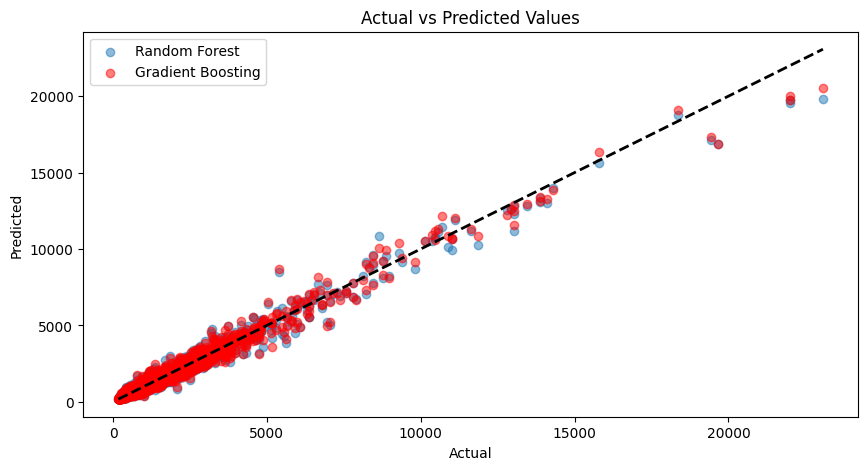

In [54]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_gb, alpha=0.5, label='Gradient Boosting', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()


Step 9: Save Best Model

In [61]:


# Select the best model based on R-squared from evaluation
if r2_gb > r2_rf:
    best_model = best_gb
    model_name = "Gradient Boosting"
else:
    best_model = best_rf
    model_name = "Random Forest"

joblib.dump(best_model, 'best_air_quality_model.pkl')
print(f"✅ Best model ({model_name}) saved as best_air_quality_model.pkl")

✅ Best model (Gradient Boosting) saved as best_air_quality_model.pkl


In [57]:
loaded_model = joblib.load('best_air_quality_model.pkl')


Step 10: Print Summary & Feature Importance

/tmp/ipython-input-63-4123309783.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')


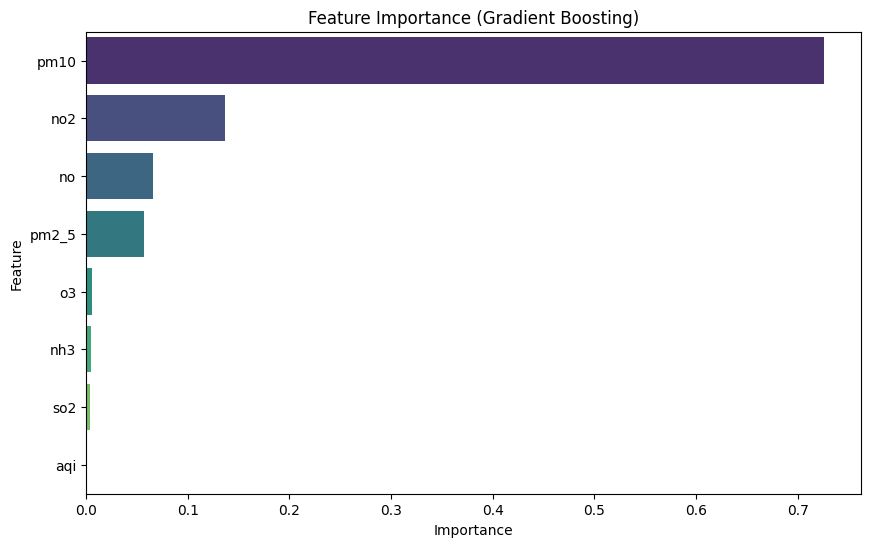

In [63]:
importances = best_model.feature_importances_
features = X.columns

imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
imp_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
plt.title(f"Feature Importance ({model_name})")
plt.show()


In [62]:
print("\n🔷 Project Summary:")
print(f"Best model: {model_name}")
print(f"R²: {max(r2_rf, r2_gb):.4f}")
print("Predictions saved to: air_quality_predictions.csv")
print("Best model saved to: best_air_quality_model.pkl")



🔷 Project Summary:
Best model: Gradient Boosting
R²: 0.9779
Predictions saved to: air_quality_predictions.csv
Best model saved to: best_air_quality_model.pkl
